# Report

## Constants / Imports

In [64]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import matplotlib.gridspec as gridspec
from lmfit import minimize
from lmfit.models import LinearModel
from matplotlib import rc
from scipy.optimize import curve_fit

# diffraction grating of NaCl
d = 5.6402e-10/2 # m
speed_of_light = 299_792_458 # m/s
electron_charge = 1.6021765e-19 # C

## Load Data:

In [65]:

all_data = []

# Load all the CSV files
for cFile in glob.glob("*.csv"):
    data = {
        "voltage": float(cFile.split(".")[0][:-2]),
        "xs": [],
        "ys": [],
        "file_name": cFile
    }
    
    with open(cFile) as csvfile:
        dialect = csv.Sniffer().sniff(csvfile.read(1024))
        csvfile.seek(0)
        lines = csv.reader(csvfile, dialect)

        header = True
        for line in lines:
            if header:
                header = False
                continue

            line = line[:2] # only grab first 2 elements

            pline = list(map(lambda x: np.float64(x), line))
            data["xs"].append(pline[0])
            data["ys"].append(pline[1])
    data["xs"] = np.float64(data["xs"])
    data["ys"] = np.float64(data["ys"])
    all_data.append(data)


This gives us an overview of all our data:

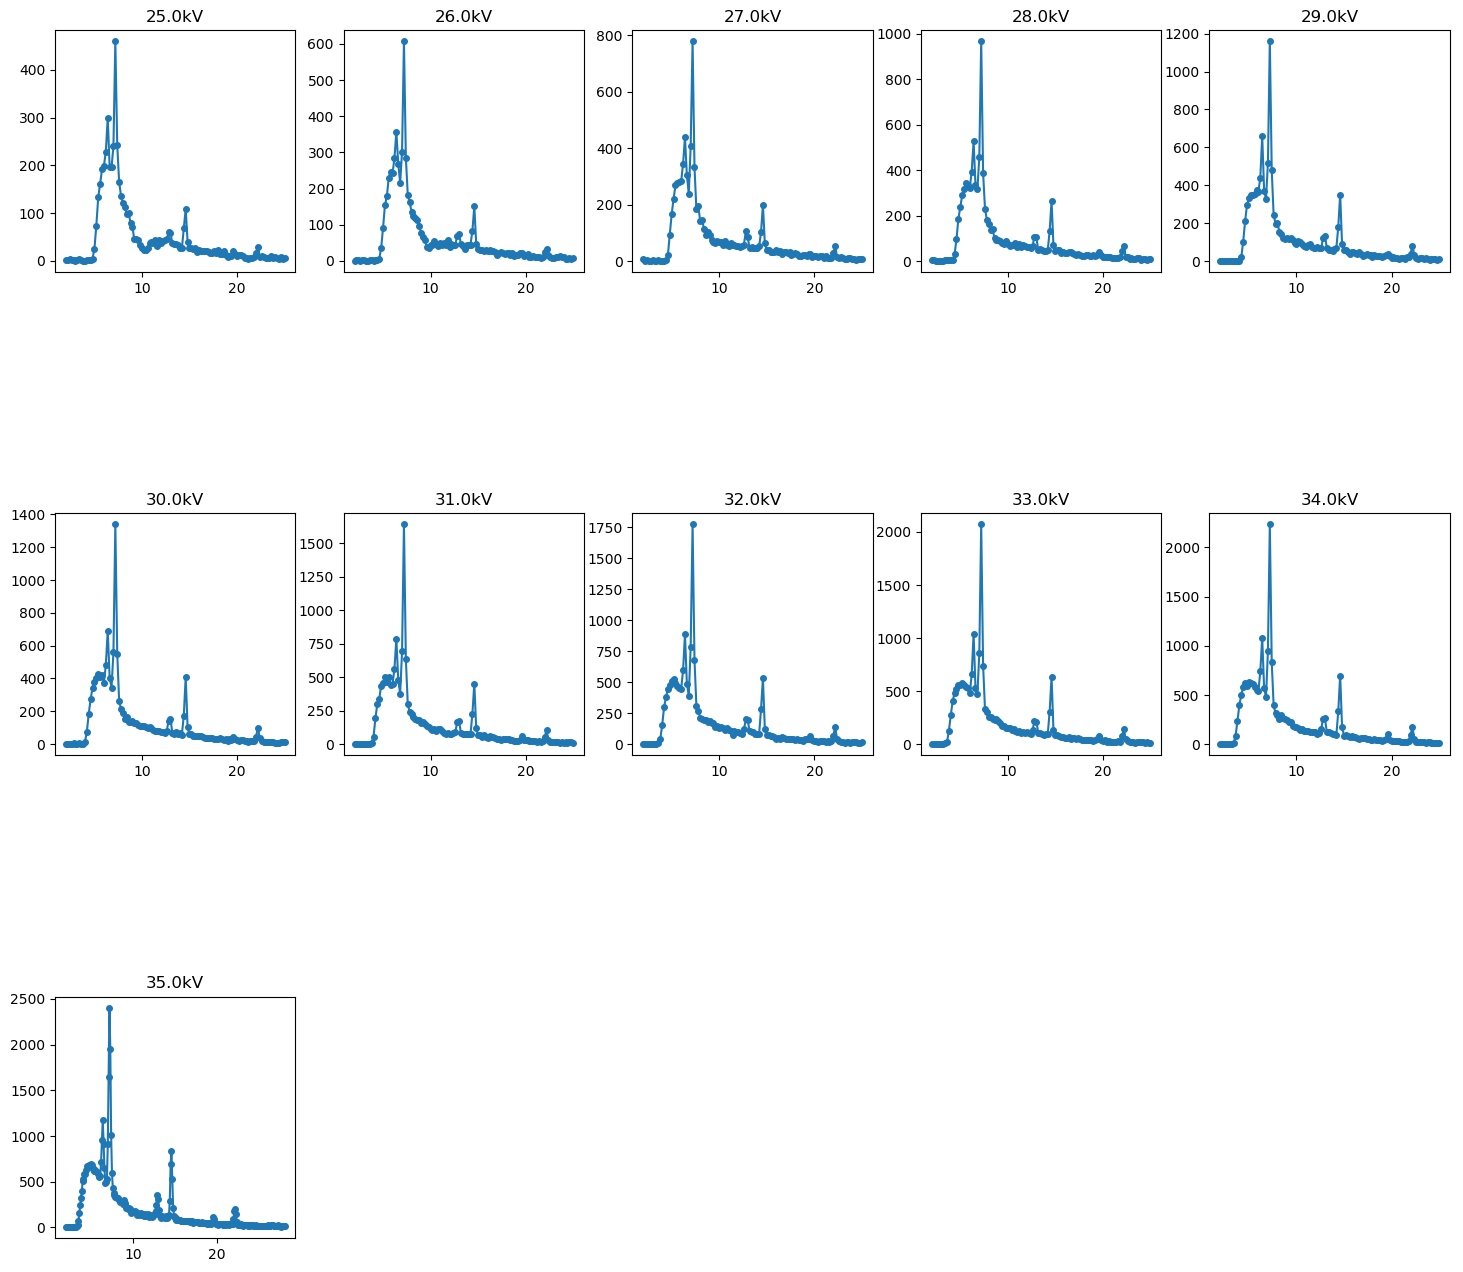

In [66]:
# plot all data
fig1 = plt.figure(figsize=(18, 16), dpi=100, facecolor='w', edgecolor='k')

cols = 5
gs = gridspec.GridSpec(len(all_data) // cols + 1, cols)
gs.update(hspace=1)

ax = []
for i, data in enumerate(all_data):
    row = (i // cols)
    col = i % cols
    ax.append(fig1.add_subplot(gs[row, col]))
    ax[-1].set_title("{}kV".format(data["voltage"]))
    ax[-1].plot(data["xs"], data["ys"], 'o', ls='-', ms=4)

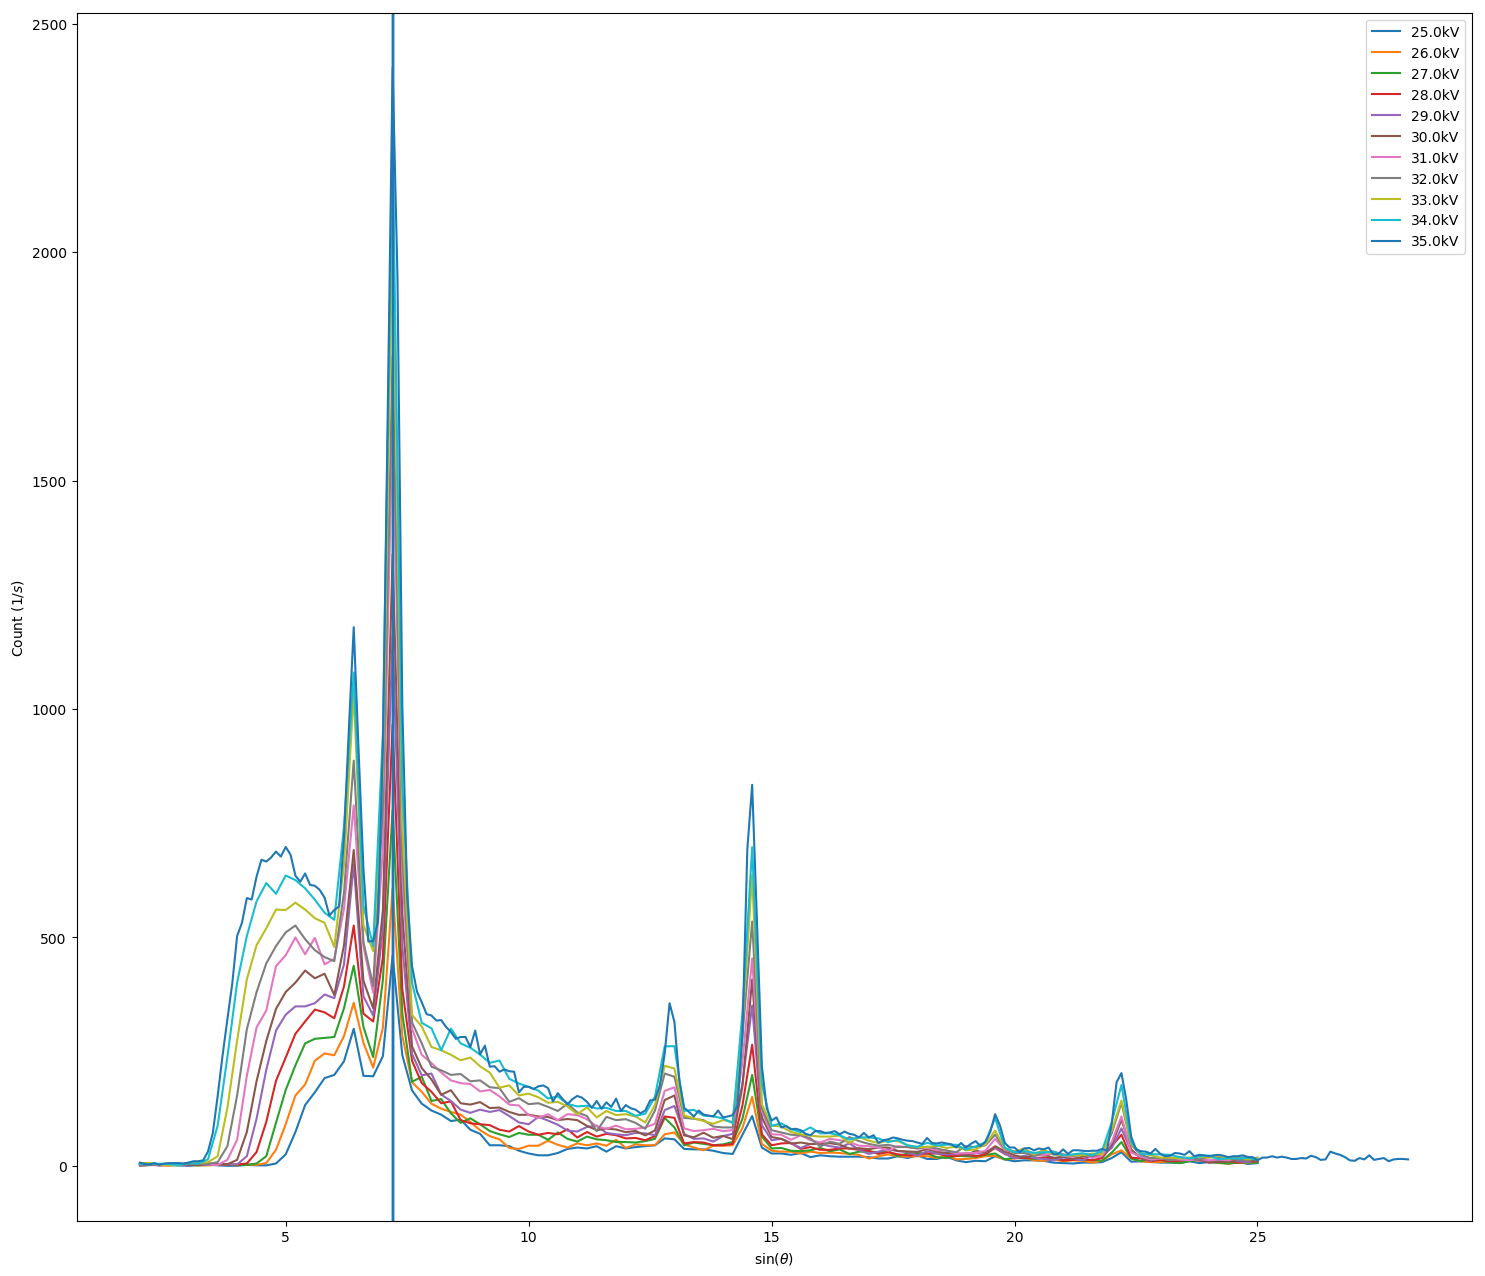

In [67]:
# Combined plot 

fig2 = plt.figure(figsize=(18, 16), dpi=100, facecolor='w', edgecolor='k')

for i, data in enumerate(all_data):

    plt.plot(data["xs"], data["ys"], label="{}kV".format(data["voltage"]))

    max_i = np.argmax(data["ys"])

    plt.axvline(x=data["xs"][max_i])

    
plt.xlabel(r"$\sin(\theta)$")
plt.ylabel(r"Count ($1/s$)")
plt.gca().legend()



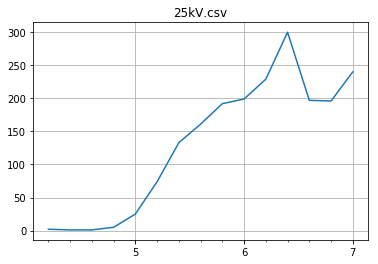

In [68]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

majorLocator = MultipleLocator(1)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.2)

min_cut_x = 4
max_cut_x = 7

plt.figure()
for i,data in enumerate(all_data):
    if data["file_name"] != "25kV.csv":
        continue
        
    min_cut = np.argmax(data["xs"]>min_cut_x)
    max_cut = np.argmax(data["xs"]>max_cut_x)
    
    sxs = data["xs"][min_cut:max_cut]
    sys = data["ys"][min_cut:max_cut]
    plt.gca().xaxis.set_major_locator(majorLocator)
    plt.gca().xaxis.set_major_formatter(majorFormatter)

    # for the minor ticks, use no labels; default NullFormatter
    plt.gca().xaxis.set_minor_locator(minorLocator)
    plt.title(data["file_name"])
    plt.plot(sxs,sys)
    plt.grid(which="major")


We can now apply a cut to see just the beginning portion of the graph to find a straight line. In this particular cut we choose
$2 \leq x \leq 7$.

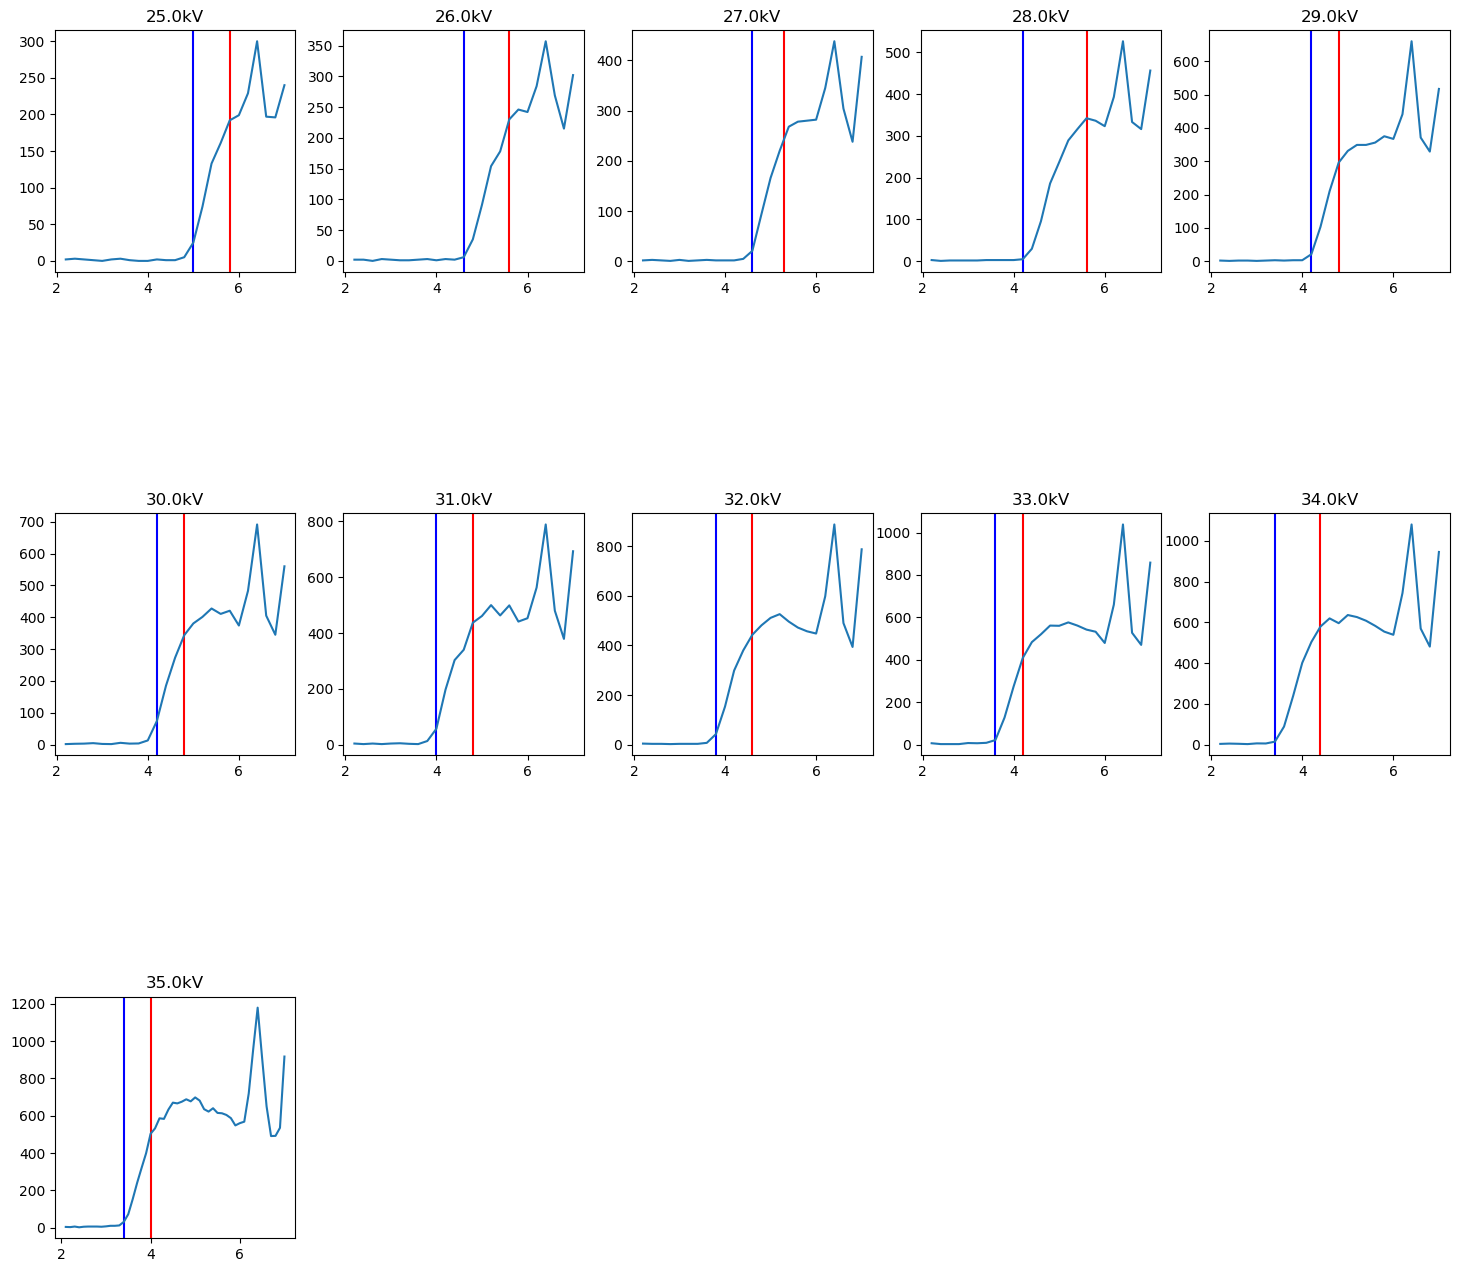

In [69]:
# 

fig3 = plt.figure(figsize=(18, 16), dpi=100, facecolor='w', edgecolor='k')

min_cut_x = 2
max_cut_x = 7

cols = 5



manual_cuts={
    "25kV.csv": [5,5.8],
    "26kV.csv": [4.6, 5.6],
    "27kV.csv": [4.6,5.3],
    "28kV.csv": [4.2,5.6],
    "29kV.csv": [4.2,4.8],
    "30kV.csv": [4.2, 4.8],
    "31kV.csv": [4,4.8],
    "32kV.csv": [3.8,4.6],
    "33kV.csv": [3.6,4.2],
    "34kV.csv": [3.4,4.4],
    "35kV.csv": [3.4,4]
}


gs = gridspec.GridSpec(len(all_data) // cols + 1, cols)
gs.update(hspace=1)

ax2 = []
for i, data in enumerate(all_data):
    row = (i // cols)
    col = i % cols
    ax2.append(fig3.add_subplot(gs[row, col]))
    
    min_cut = np.argmax(data["xs"]>min_cut_x)
    max_cut = np.argmax(data["xs"]>max_cut_x)
    
    sxs = data["xs"][min_cut:max_cut]
    sys = data["ys"][min_cut:max_cut]
    
    x_min,x_max = manual_cuts[data["file_name"]]
    
    ax2[-1].axvline(x=x_min, color="b")
    ax2[-1].axvline(x=x_max, color="r")
    
    x_min_i = np.argmax(data["xs"]>x_min)
    x_max_i = np.argmax(data["xs"]>=x_max)
    
    ax2[-1].plot(sxs,sys ,  label="{}kV".format(data["voltage"]))
    ax2[-1].set_title("{}kV".format(data["voltage"]))
    all_data[i]["x_min_i"] = x_min_i
    all_data[i]["x_max_i"] = x_max_i

    #plt.xlabel(r"$\sin(\theta)$")
    #plt.ylabel(r"Count ($1/s$)")
    #ax2[-1].gca().legend()


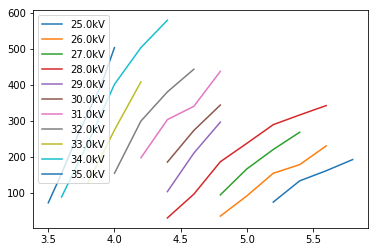

In [70]:
for data in all_data:
    sxs = data["xs"][data["x_min_i"]:data["x_max_i"]+1]
    sys = data["ys"][data["x_min_i"]:data["x_max_i"]+1]
    plt.plot(sxs,sys,label="{}kV".format(data["voltage"]))
    plt.legend()


h = 6.710380268709618 +- 0.6567726677152358 x10^-34


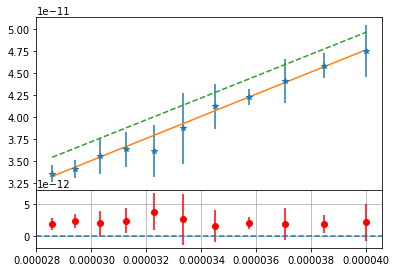

In [71]:

def linear_model(x,a,b):
    return a*x + b




plt.figure()
final_xs = []
final_ys = []
sigma_ys = []


for data in all_data:

    sxs = data["xs"][data["x_min_i"]:data["x_max_i"]+1]
    sys = data["ys"][data["x_min_i"]:data["x_max_i"]+1]
    (gradient, yint), pcov = curve_fit(linear_model,sxs,sys,sigma=0.03*sys,absolute_sigma=True)
    
    
    grad_err,y_int_err = np.diag(pcov)**0.5
    
    x_int = -yint/gradient
    x_int_err = x_int * ( (grad_err/gradient)**2 + (y_int_err/yint)**2 )**0.5
    
    x_int = np.radians(x_int)  # x_int/360 * 2pi
    x_int_err = np.radians(x_int_err)
    
    # 2 d sin -yint/gradient
    min_wavelength = 2 * d* np.sin(x_int) 
    
    # assume d has no uncertainity
    min_wv_err = 2 * d * np.abs(np.cos(x_int)) * x_int_err
    final_ys.append(min_wavelength)
    sigma_ys.append(min_wv_err)
    final_xs.append(1/(data["voltage"]*10**3))

final_xs = np.float64(final_xs)
final_ys = np.float64(final_ys)
sigma_ys = np.float64(sigma_ys)
    
#PLOT
fig1 = plt.figure(1)
#Plot Data-model
frame1=fig1.add_axes((.1,.3,.8,.6))

#check that
(gradient, yint), pcov = curve_fit(linear_model,final_xs,final_ys, sigma=sigma_ys,absolute_sigma=True)
    
plt.errorbar(final_xs, final_ys, yerr=sigma_ys, fmt="*")


line_xs = np.linspace(np.min(final_xs), np.max(final_xs), 500)
line_ys = linear_model(line_xs, gradient, yint)

plt.plot(line_xs,line_ys)
frame1.set_xticklabels([])

h = electron_charge * gradient/(speed_of_light)
h_err = electron_charge * (pcov[0,0]**0.5)/(speed_of_light) 
print("h = {} +- {} x10^-34".format(h*10**34, h_err*10**34))


ac_h = np.float64(6.626_070_040e-34)
ac_h_line_ys = linear_model(line_xs, (ac_h * 3e8)/(1.602e-19), 0)
ac_h_ys = linear_model(final_xs, (ac_h * 3e8)/(1.602e-19), 0)

plt.plot(line_xs, ac_h_line_ys, label="ac",linestyle="--")



res_y = ac_h_ys - final_ys

frame2=fig1.add_axes((.1,.1,.8,.2))        
plt.axhline(y=0, linestyle="--")
plt.errorbar(final_xs,res_y,fmt='or',yerr=sigma_ys)
plt.grid()

# $K_\alpha$ and $K_\beta$ peaks

k_a = 7.069045039493887e-11 +- 6.360498660782849e-13


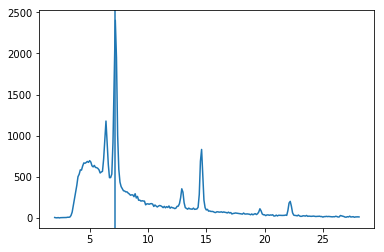

In [72]:

for i, data in enumerate(all_data):
    k_alph_i =np.argmax(data["ys"])
    k_alph_ang = np.radians(data["xs"][k_alph_i])
    
    k_alph_ang_err = k_alph_ang*0.03
    
    k_alph_wv = 2 * d * np.sin(k_alph_ang)
    
    k_alph_wv_err = 2 * d * np.abs(np.cos(k_alph_ang)) * k_alph_ang_err
    
    data["k_alph_i"] = k_alph_i
    data["k_alph_wv"] = k_alph_wv
    data["k_alph_wv_err"] = k_alph_wv_err
    
    if i == len(all_data)-1:
        plt.plot(data["xs"], data["ys"])
        plt.axvline(x=np.degrees(k_alph_ang))

all_k_alph_wv = np.array([data["k_alph_wv"] for data in all_data])
all_k_alph_wv_err = np.array([data["k_alph_wv_err"] for data in all_data])
    
    
k_alph_weight = 1/all_k_alph_wv_err**2
mean_k_alph_wv = np.sum(k_alph_weight * all_k_alph_wv)/np.sum(k_alph_weight)


mean_k_alph_wv_err = (1/np.sum(k_alph_weight))**0.5
print("k_a =", mean_k_alph_wv, "+-", mean_k_alph_wv_err)

k_b = 6.287070714301171e-11 +- 5.663197800796633e-13


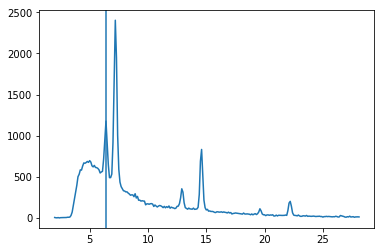

In [73]:

for i, data in enumerate(all_data):
        
    
    # k_b must be < k_a
    restricted_ys = data["ys"][:data["k_alph_i"]-1]
    k_beta_ang = np.radians(data["xs"][np.argsort(restricted_ys)[-1]])
    
    k_beta_ang_err = k_beta_ang*0.03
    
    k_beta_wv = 2 * d * np.sin(k_beta_ang)
    
    k_beta_wv_err = 2 * d * np.abs(np.cos(k_beta_ang)) * k_beta_ang_err
    
    data["k_beta_wv"] = k_beta_wv
    data["k_beta_wv_err"] = k_beta_wv_err
    
    if i == len(all_data)-1:
        plt.plot(data["xs"], data["ys"])
        plt.axvline(x=np.degrees(k_beta_ang))

all_k_beta_wv = np.array([data["k_beta_wv"] for data in all_data])
all_k_beta_wv_err = np.array([data["k_beta_wv_err"] for data in all_data])
    
    
k_beta_weight = 1/all_k_beta_wv_err**2
mean_k_beta_wv = np.sum(k_beta_weight * all_k_beta_wv)/np.sum(k_beta_weight)

mean_k_beta_wv_err = (1/np.sum(k_beta_weight))**0.5

print("k_b =", mean_k_beta_wv, "+-", mean_k_beta_wv_err)